In [1]:
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import MaxAbsScaler
import xarray as xr

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

# %load_ext rich
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data_path = "https://raw.githubusercontent.com/juanitorduz/website_projects/master/data/ktr_data.csv"
data_df = pd.read_csv(data_path, parse_dates=["date"])

In [3]:
data_df.head()

index       date  year  month  dayofyear         z  z_adstock  \
0      0 2018-04-02  2018      4         92  0.936350   0.936350   
1      1 2018-04-09  2018      4         99  9.507143   9.975318   
2      2 2018-04-16  2018      4        106  7.319939  12.307599   
3      3 2018-04-23  2018      4        113  5.986585  12.140384   
4      4 2018-04-30  2018      4        120  0.390047   6.460239   

   z_adstock_saturated      beta  z_effect  effect_ratio  effect_ratio_smooth  \
0             0.070111  1.000000  0.070111      0.074877             0.062576   
1             0.634043  0.990022  0.627717      0.062927             0.062525   
2             0.727346  0.980198  0.712944      0.057927             0.062426   
3             0.721386  0.970526  0.700123      0.057669             0.062280   
4             0.449855  0.961000  0.432310      0.066919             0.062093   

      trend        cs        cc  seasonality  intercept  trend_plus_intercept  \
0  0.778279  0.021487 -0.010744     0.002686        3.0              3.778279   
1  0.790638  0.259165 -0.130704     0.032115        3.0              3.790638   
2  0.802746  0.481904 -0.248773     0.058283        3.0              3.802746   
3  0.814614  0.676865 -0.363245     0.078405        3.0              3.814614   
4  0.826254  0.832810 -0.472462     0.090087        3.0              3.826254   

    epsilon         y  
0  0.014901  3.865978  
1 -0.004179  4.446291  
2  0.019722  4.593694  
3  0.046718  4.639861  
4 -0.007235  4.341417

In [4]:
columns_to_keep = ["index", "date", "year", "month", "dayofyear", "z", "y"]
df = data_df[columns_to_keep].copy()

In [5]:
df.describe()

index                 date         year       month   dayofyear  \
count  179.000000                  179   179.000000  179.000000  179.000000   
mean    89.000000  2019-12-16 00:00:00  2019.458101    6.508380  182.597765   
min      0.000000  2018-04-02 00:00:00  2018.000000    1.000000    4.000000   
25%     44.500000  2019-02-07 12:00:00  2019.000000    4.000000  103.000000   
50%     89.000000  2019-12-16 00:00:00  2019.000000    6.000000  181.000000   
75%    133.500000  2020-10-22 12:00:00  2020.000000    9.000000  262.500000   
max    178.000000  2021-08-30 00:00:00  2021.000000   12.000000  365.000000   
std     51.816986                  NaN     1.045149    3.271203  100.370019   

                z           y  
count  179.000000  179.000000  
mean     4.061779    4.635470  
min      0.013805    3.650110  
25%      0.560754    4.460362  
50%      4.722149    4.636277  
75%      7.293067    4.868279  
max      9.868869    5.370176  
std      3.522704    0.341397

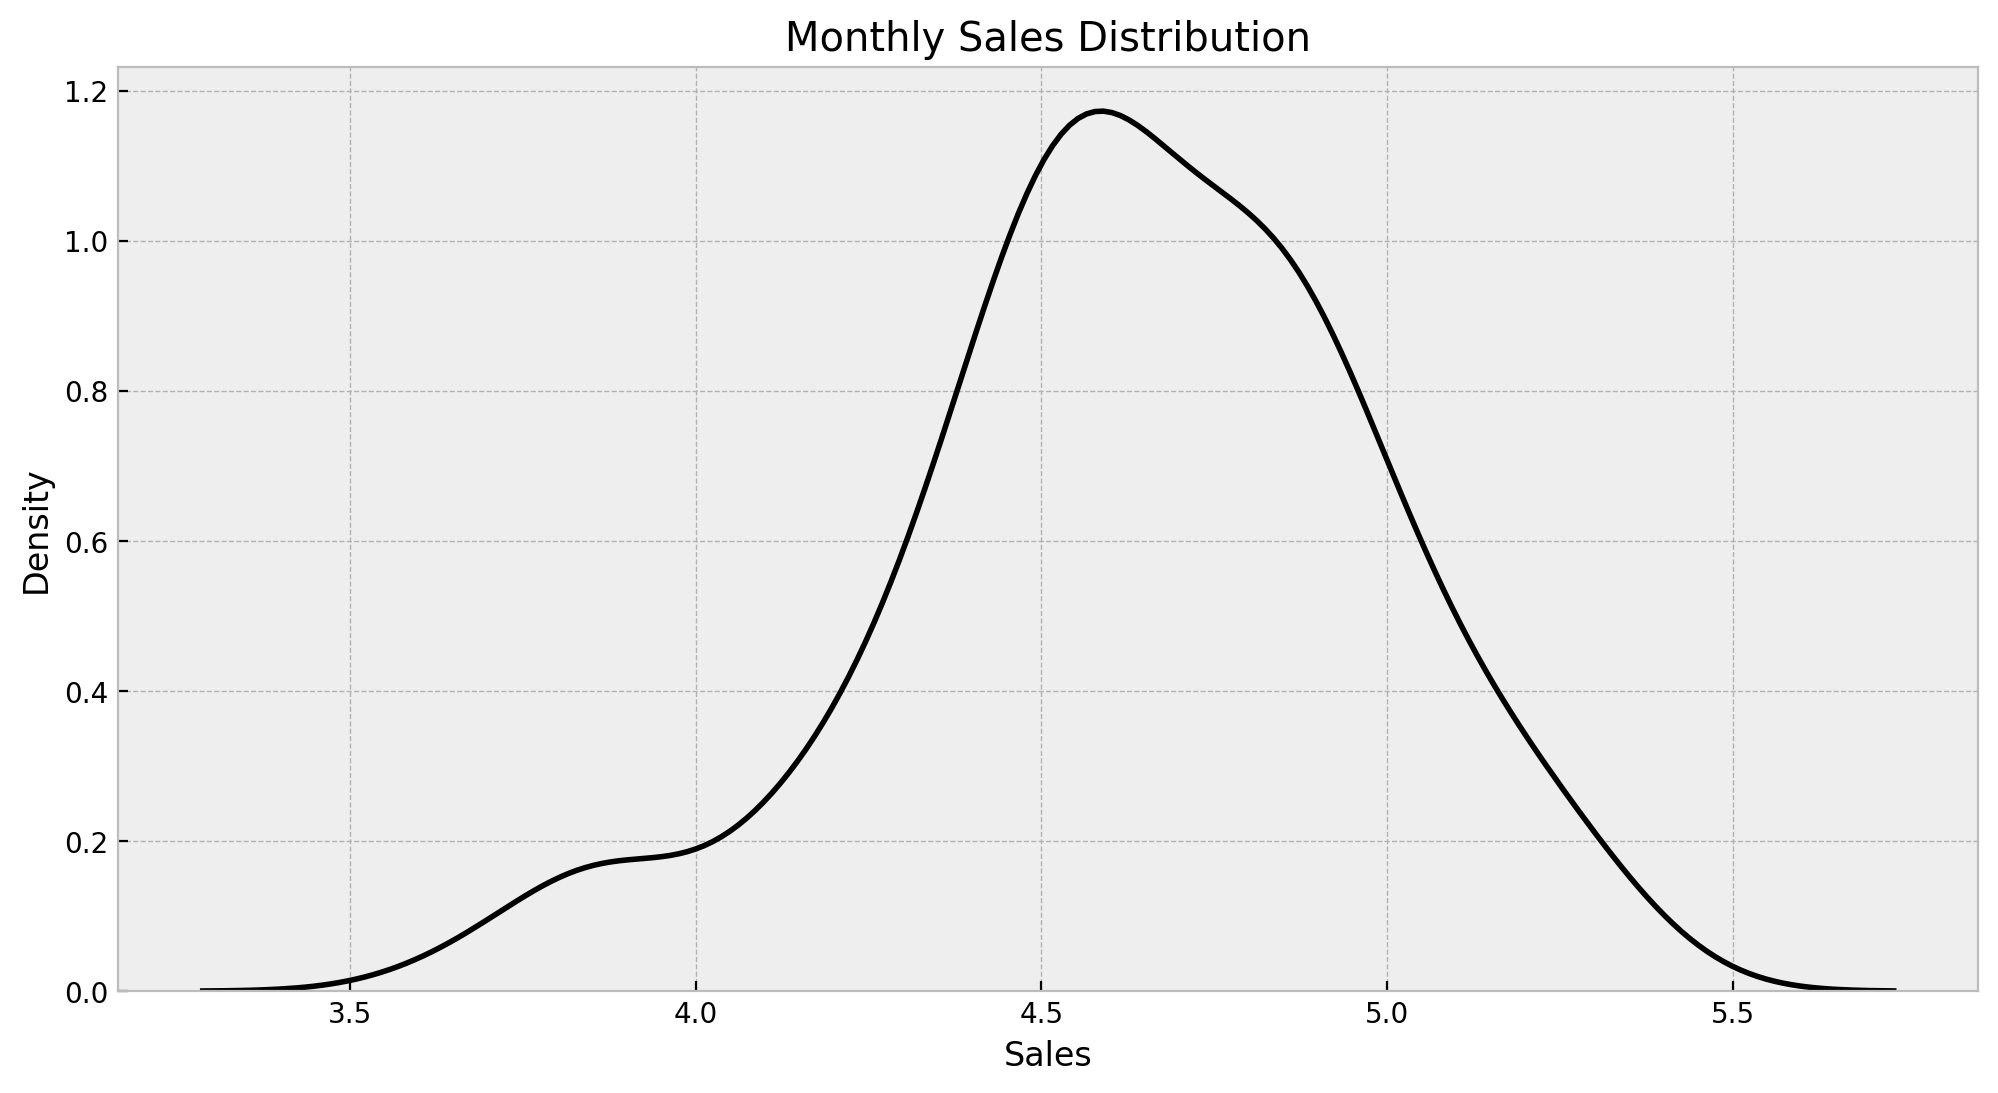

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(x="y", color="black", data=df, ax=ax)
_ = ax.set(title="Monthly Sales Distribution", xlabel="Sales")

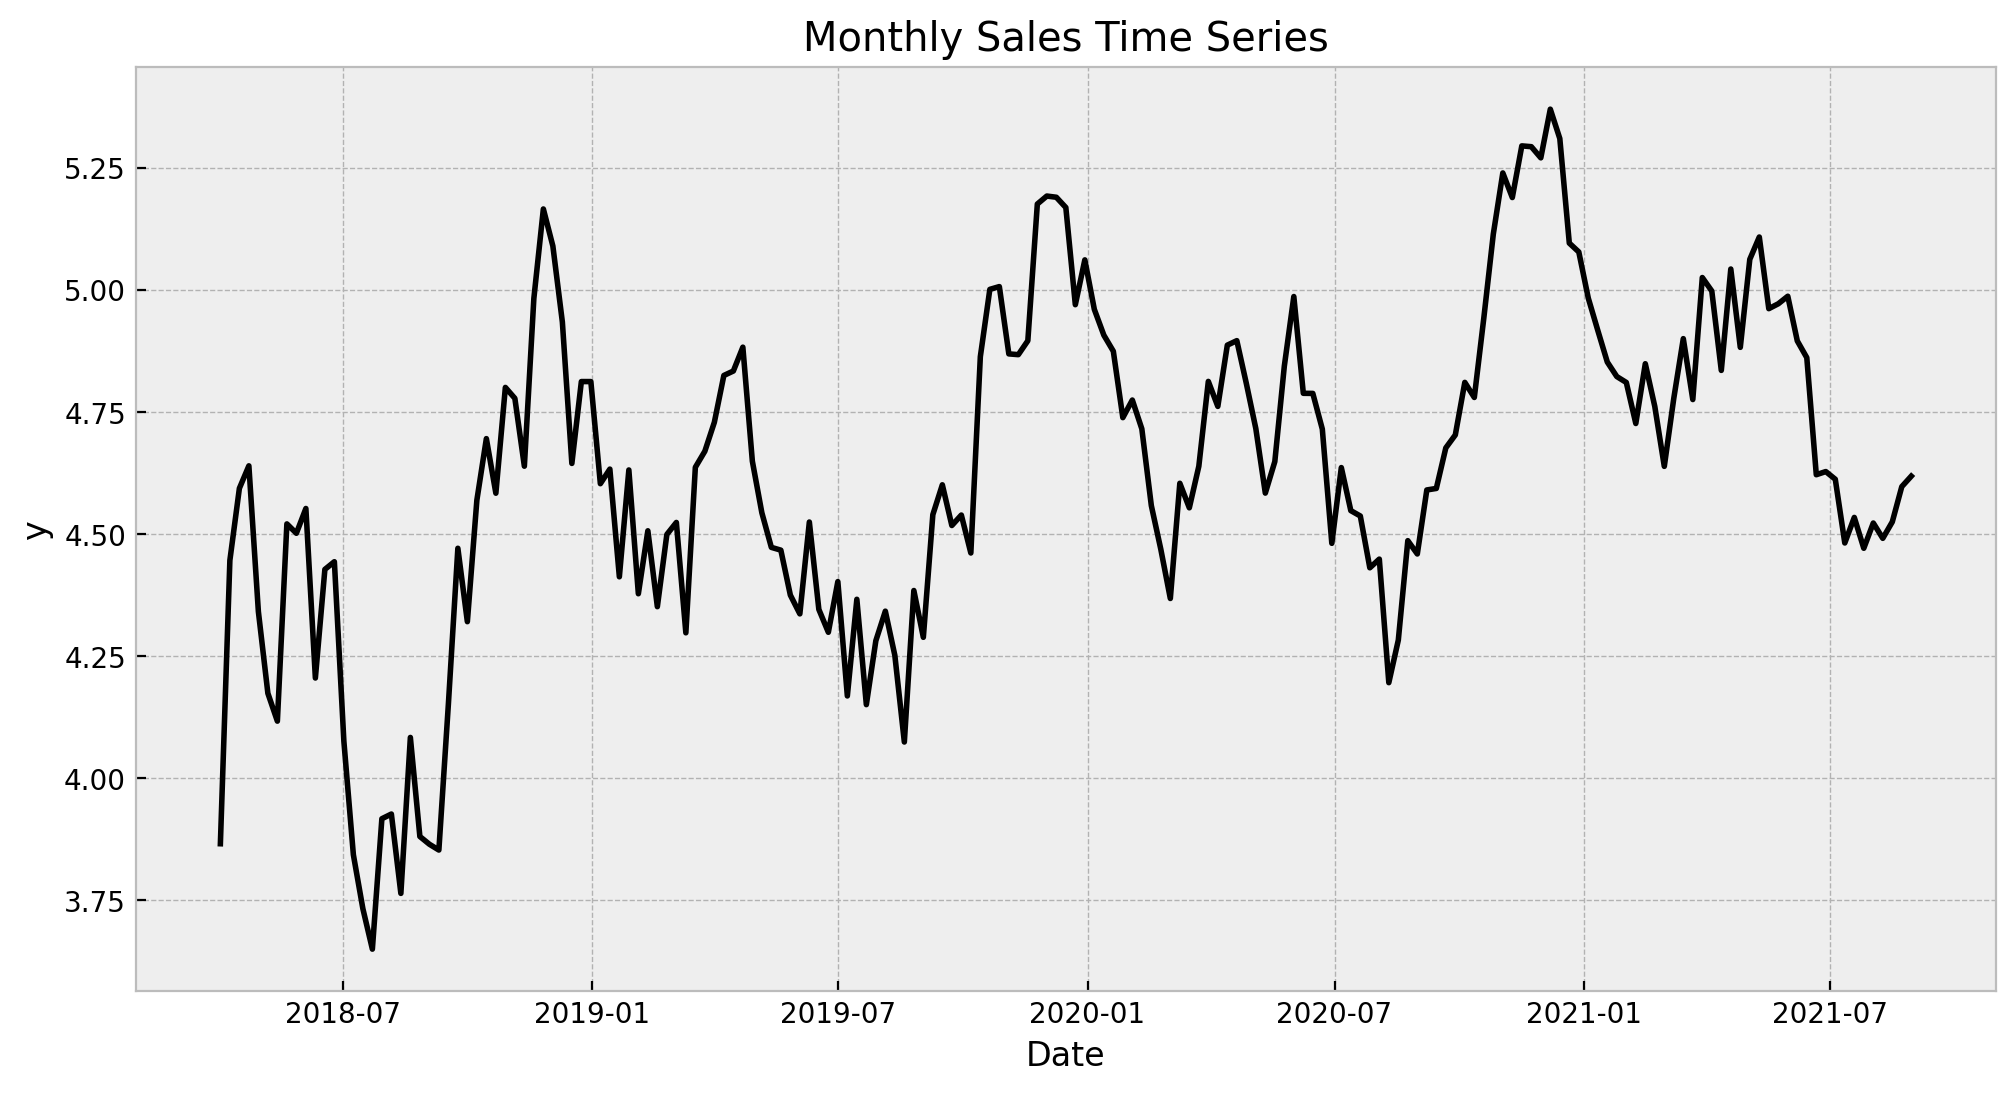

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x="date", y="y", color="black", data=df, ax=ax)
_ = ax.set(title="Monthly Sales Time Series", xlabel="Date")

# Understanding The Data

## Data Generation Process
From the `kdeplot` above, we notice that we typically had weekly sales of 4.5 units(expectation) with some potential outliers on the left of the distribution. Because of that and only that, we assume a `Student T distribution` as a suitable model for modelling the data-generation process of sales.

## Feature Engineering
We also learn from the sales trend that - generally speaking - we have sales increasing with some seasonality spikes. In order to clearly include these(seasonality and trend) into our modelling, it would help to engineer new features to indicate these.

#### Trend Feature
For the sake of simplicty, perhaps interpretability also, it might be wise to just think of the trend component as linear and restrict it between 0 and 1. *I don't have any further reasons for this choice, it's also mostly for computational convenience*. Therefore, we'll define the trend as follows:
$$
    t_i = \frac{i - \min(I)}{\max(I) - \min(I)}, \text{$\forall{i \in I}$ where $I$ is the list of all indices for observations}
$$

#### Seasonality Feature
In the time period in which we've been recording the data, we see 7 seasonal spikes, beyond that, I'm not see what's going on here.

In [8]:
trend_feature = (df.index - df.index.min()) / (df.index.max() - df.index.min())
print(f"{trend_feature[:4].tolist()} ... {trend_feature[-4:].tolist()}")

[0.0, 0.0056179775280898875, 0.011235955056179775, 0.016853932584269662] ... [0.9831460674157303, 0.9887640449438202, 0.9943820224719101, 1.0]


In [9]:
n_order = 7
periods = df["dayofyear"] / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)
fourier_features.head()

sin_order_1  cos_order_1  sin_order_2  cos_order_2  sin_order_3  \
0     0.999930    -0.011826    -0.023651    -0.999720    -0.999371   
1     0.991269    -0.131859    -0.261414    -0.965227    -0.922329   
2     0.968251    -0.249981    -0.484089    -0.875019    -0.726225   
3     0.931210    -0.364483    -0.678820    -0.734304    -0.436373   
4     0.880683    -0.473706    -0.834370    -0.551205    -0.090190   

   cos_order_3  sin_order_4  cos_order_4  sin_order_5  cos_order_5  \
0     0.035473     0.047289     0.998881     0.998252    -0.059099   
1     0.386405     0.504648     0.863325     0.789245    -0.614079   
2     0.687457     0.847173     0.531317     0.302670    -0.953095   
3     0.899766     0.996922     0.078406    -0.290349    -0.956921   
4     0.995925     0.919817    -0.392347    -0.781257    -0.624210   

   sin_order_6  cos_order_6  sin_order_7  cos_order_7  
0    -0.070900    -0.997483    -0.996575     0.082692  
1    -0.712786    -0.701382    -0.601271     0.799045  
2    -0.998497    -0.054805     0.196540     0.980496  
3    -0.785267     0.619157     0.862782     0.505576  
4    -0.179645     0.983732     0.951454    -0.307790

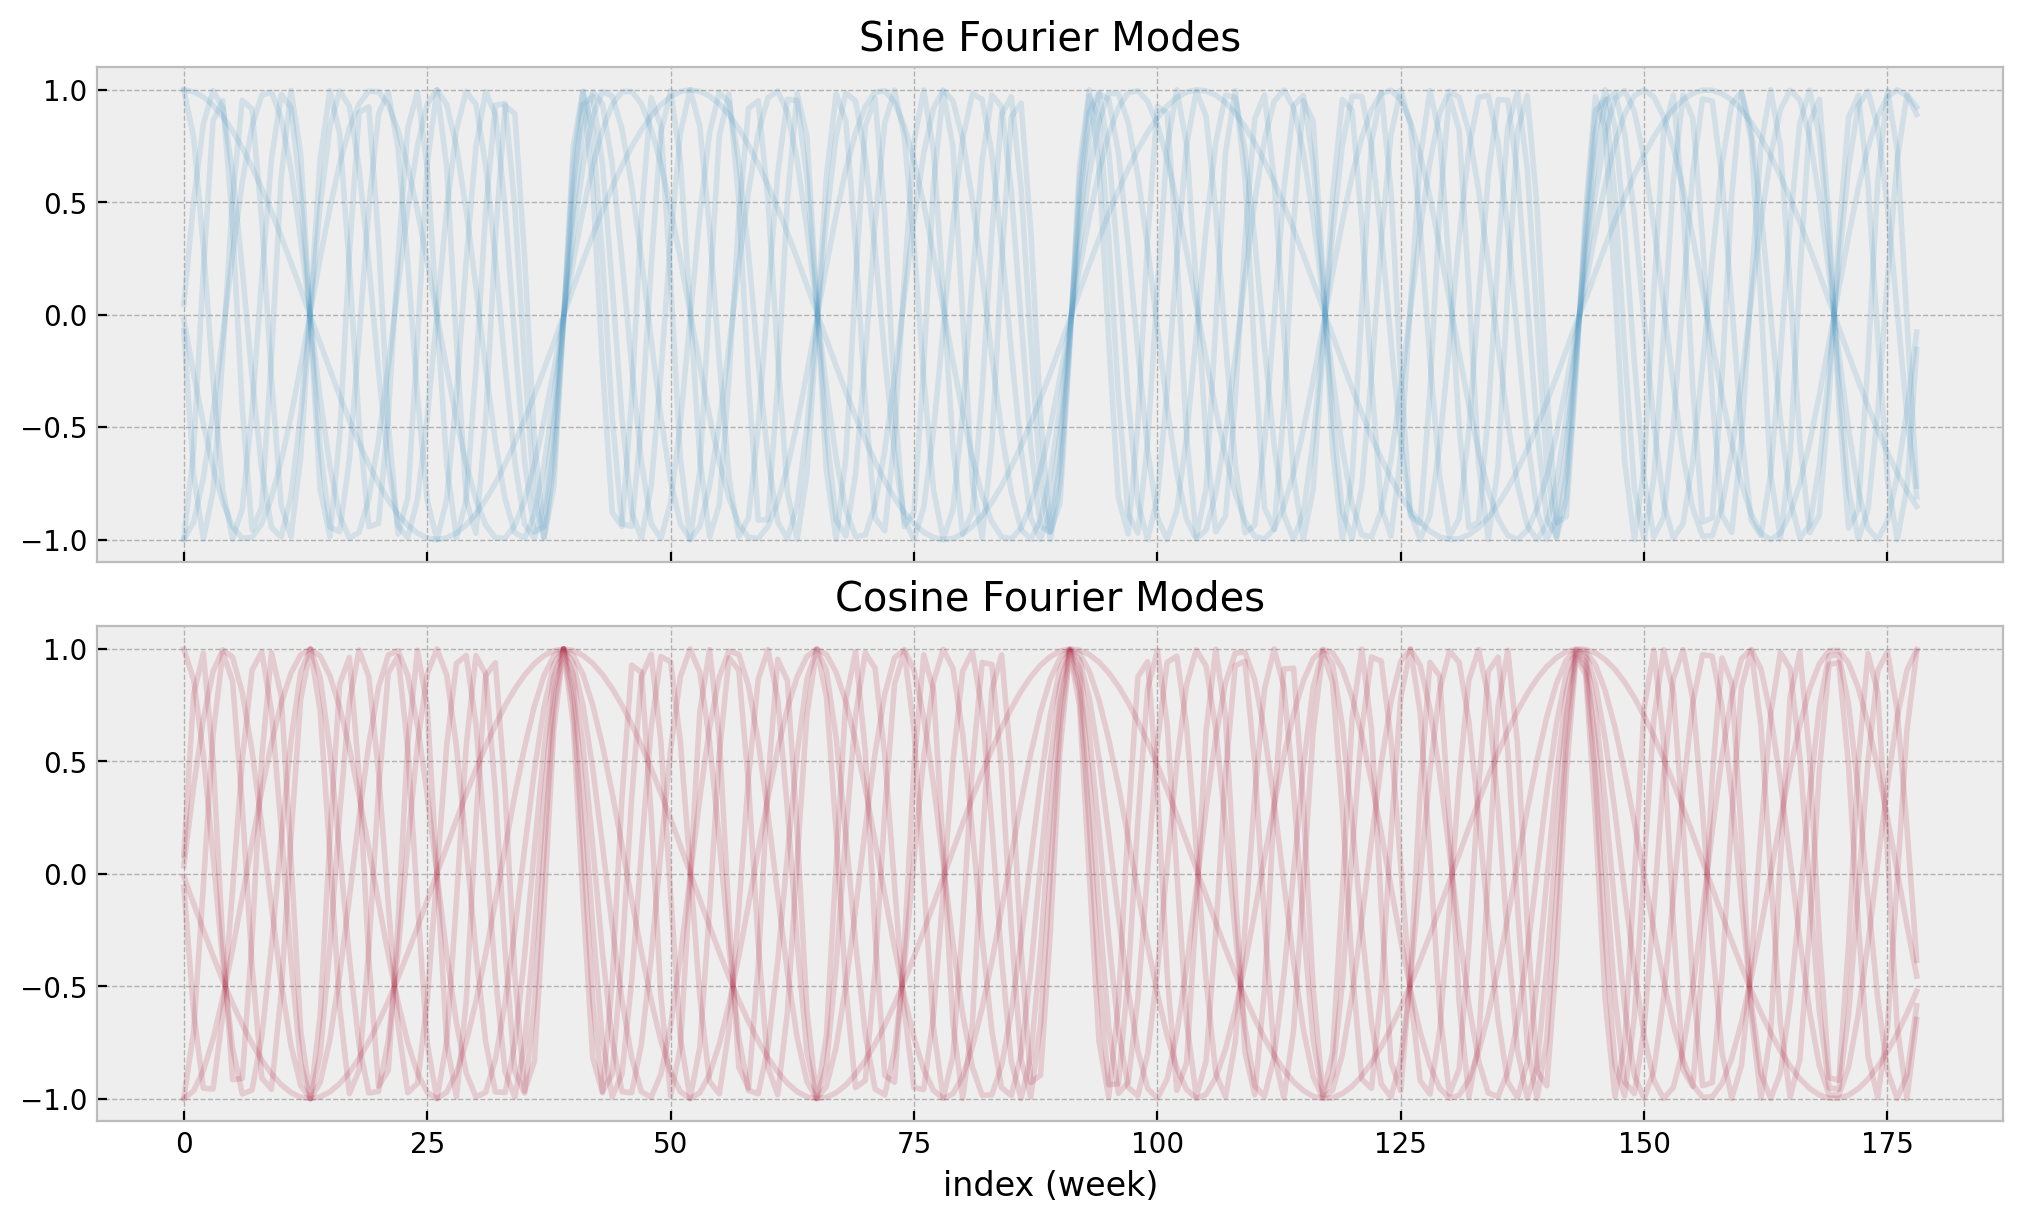

In [10]:
fig, ax = plt.subplots(nrows=2, sharex=True, layout="constrained")
fourier_features.filter(like="sin").plot(color="C0", alpha=0.15, ax=ax[0])
ax[0].get_legend().remove()
ax[0].set(title="Sine Fourier Modes", xlabel="index (week)")
fourier_features.filter(like="cos").plot(color="C1", alpha=0.15, ax=ax[1])
ax[1].get_legend().remove()
ax[1].set(title="Cosine Fourier Modes", xlabel="index (week)");

## Scaling

We use the `MaxAbsScaler` to scale `y` and `z`, we'll come back to why this is important when we talk about ROAS and mROAS. However, on a general note, 

In [11]:
date = df["date"].to_numpy()
date_index = df.index
y = df["y"].to_numpy()
z = df["z"].to_numpy()
trend_feature = trend_feature.values
n_obs = y.size

In [12]:
endog_scaler = MaxAbsScaler()
endog_scaler.fit(y.reshape(-1, 1))
y_scaled = endog_scaler.transform(y.reshape(-1, 1)).flatten()

channel_scaler = MaxAbsScaler()
channel_scaler.fit(z.reshape(-1, 1))
z_scaled = channel_scaler.transform(z.reshape(-1, 1)).flatten()

# Modelling

## The Base Model
As is a well-founded convention to always start small and build your up. We're going to start with a base model that uses `z` as a regressor and controls for `seasonality` and `trend`. Our initial thought is that the expectation($\mu$) of the Student T as assumed above, is measurely influenced by trend, seasonality and the effect of z($\text{z\_effect}$) as follows:


In [37]:
coords = {"date": date, "fourier_mode": np.arange(2 * n_order)}

with pm.Model(coords=coords) as base_model:
    base_model.add_coord(name="date", values=date, mutable=True)
    base_model.add_coord(name="fourier_mode", values=np.arange(2 * n_order), mutable=False)

    # CONTAINED DATA
    z_scaled_ = pm.MutableData(name="z_scaled", value=z_scaled, dims="date")
    y_scaled_ = pm.MutableData(name="y_scaled", value=y_scaled, dims="date")

    # PRIOR INFORMATION - for alpha & 
    α = pm.Normal(name="α", mu=0, sigma=4)
    b_trend = pm.Normal(name="b_trend", mu=0, sigma=2)
    b_fourier = pm.Laplace(name="b_fourier", mu=0, b=2, dims="fourier_mode")
    b_z = pm.HalfNormal(name="b_z", sigma=2)
    σ = pm.HalfNormal(name="σ", sigma=0.5)
    

    # MODEL PARAMETERIZATION
    trend = pm.Deterministic(name="trend", var=α + b_trend * trend_feature, dims="date")
    seasonality = pm.Deterministic(
        name="seasonality",
        var=pm.math.dot(fourier_features, b_fourier),
        dims="date"
    )
    z_effect = pm.Deterministic(name="z_effect", var=b_z * z_scaled_, dims="date")

    ν = pm.Gamma(name="ν", alpha=25, beta=2)
    μ = pm.Deterministic(name="μ", var=trend + seasonality + z_effect, dims="date")

    # LIKELIHOOD
    pm.StudentT(name="likelihood", nu=ν, mu=μ, sigma=σ, observed=y_scaled_, dims="date")

In [38]:
# PRIOR PREDICTIVE SAMPLING
with base_model:
    base_model_prior_predictive = pm.sample_prior_predictive()

Sampling: [b_fourier, b_trend, b_z, likelihood, α, ν, σ]


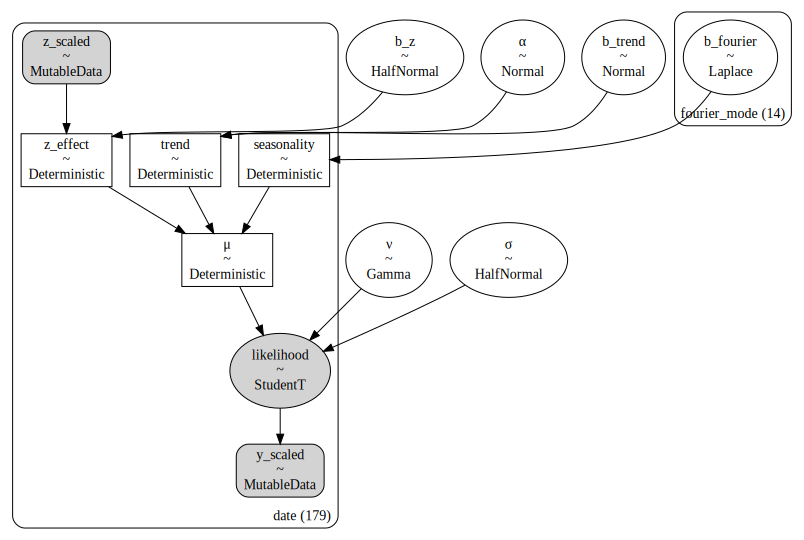

In [39]:
pm.model_to_graphviz(model=base_model)

# Prior Predictive Checking

So far everything is clear, what's not clear is the logic behind the visual used to display the prior predictive samples and what it means. I don't know how to interpret it. We'll get back to it.

<Axes: xlabel='likelihood / likelihood'>

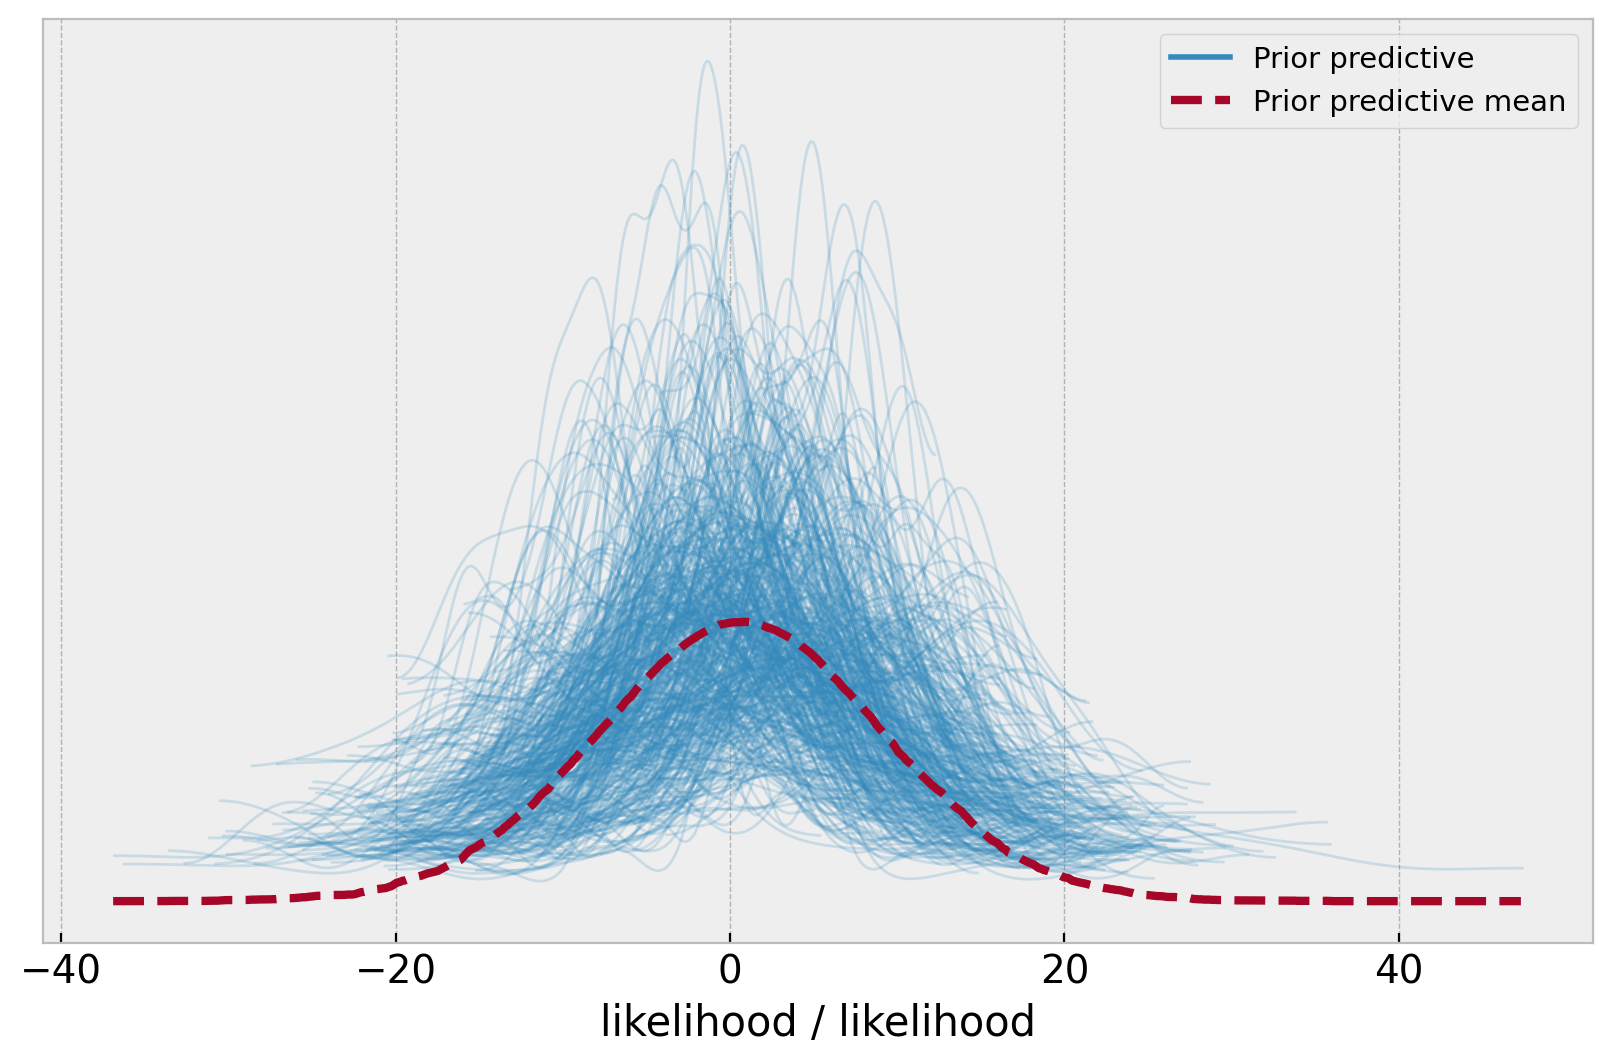

In [48]:
az.plot_ppc(base_model_prior_predictive, observed=False, group="prior")

# Posterior Predictive Checking

Let us now fit the model to the data and then assess how well the model(data generated from the model) fits observed data.

In [17]:
with base_model:
    base_model_trace = pm.sample(
        nuts_sampler="numpyro",
        draws=6_000,
        chains=4,
        idata_kwargs={"log_likelihood": True},
    )

    # POSTERIOR PREDICTIVE SAMPLING
    base_model_posterior_predictive = pm.sample_posterior_predictive(
        trace=base_model_trace
    )

Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:12.801193
Sampling...


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

Sampling time =  0:00:14.416896
Transforming variables...
Transformation time =  0:00:00.719528
Computing Log Likelihood...


Sampling: [likelihood]


Log Likelihood time =  0:00:00.533456


In [50]:
az.summary(
    data=base_model_trace,
    var_names=["α", "b_trend", "b_z", "σ", "ν"],
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
α         0.788  0.003   0.782    0.794      0.000    0.000    9622.0   
b_trend   0.119  0.005   0.110    0.127      0.000    0.000   11665.0   
b_z       0.049  0.004   0.042    0.056      0.000    0.000    9646.0   
σ         0.016  0.001   0.014    0.018      0.000    0.000   10488.0   
ν        12.524  2.427   8.117   17.113      0.023    0.017   10587.0   

         ess_tail  r_hat  
α         12932.0    1.0  
b_trend   14022.0    1.0  
b_z       11861.0    1.0  
σ         13140.0    1.0  
ν         12220.0    1.0

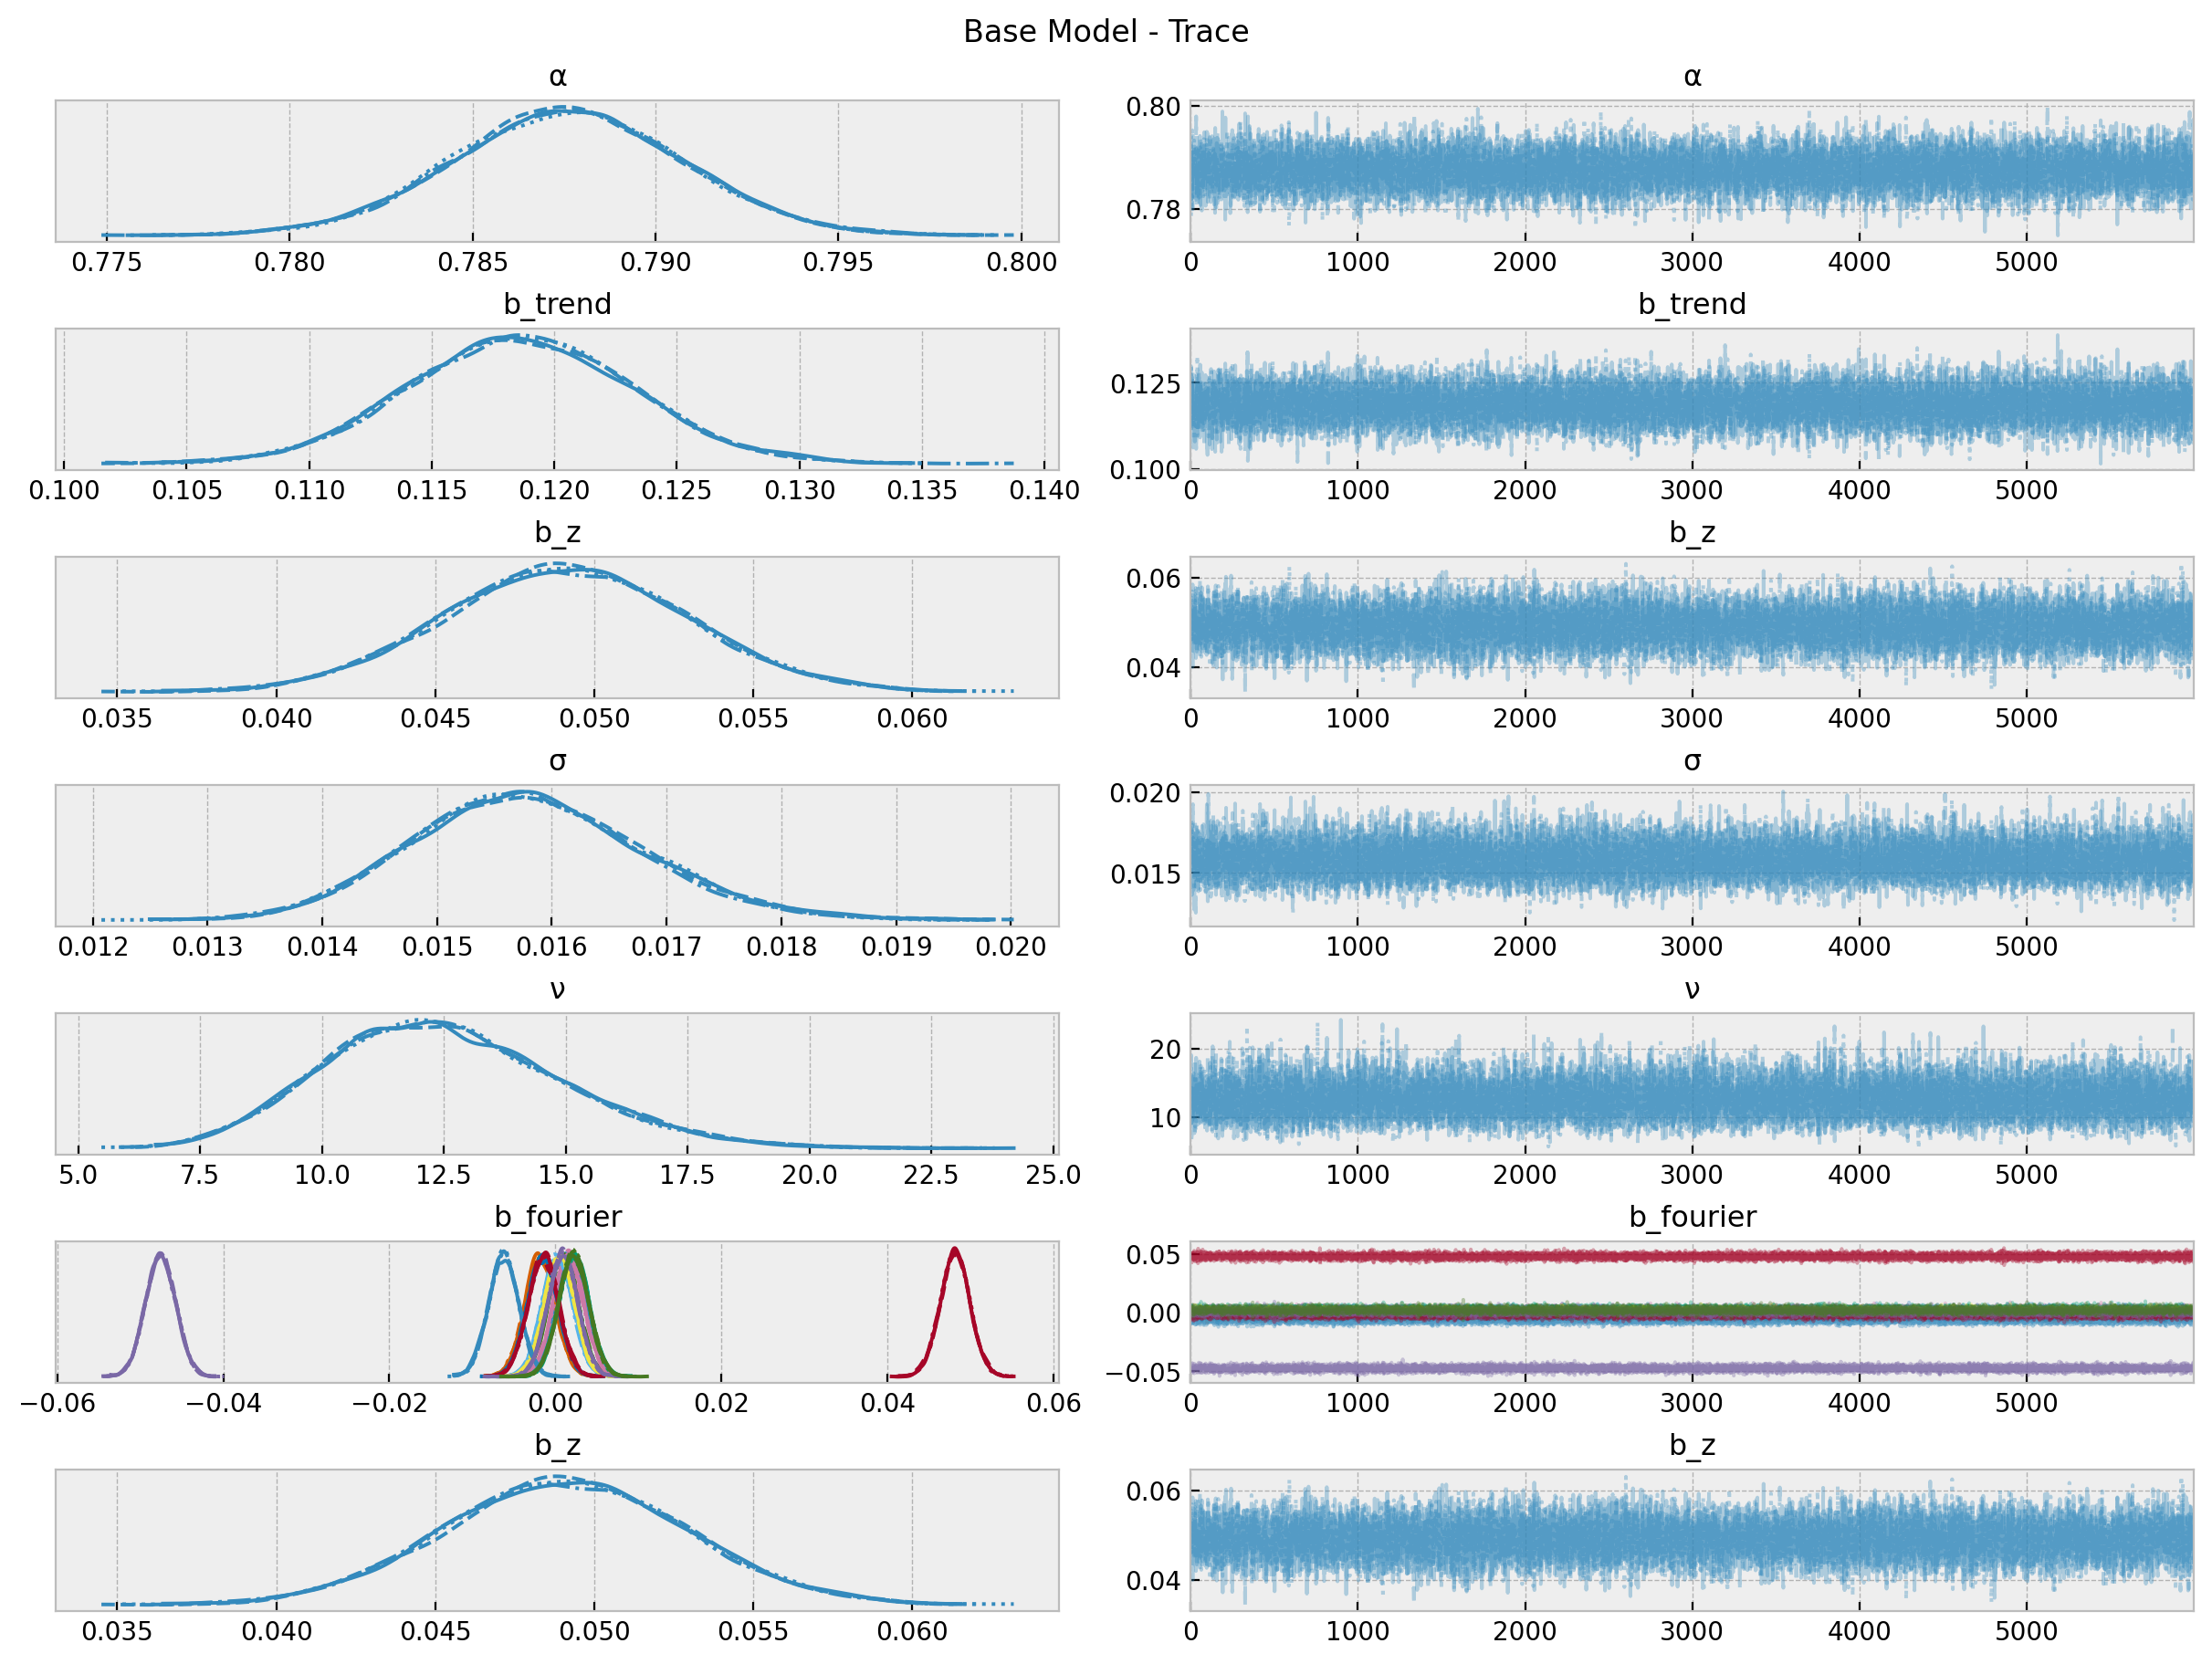

In [51]:
axes = az.plot_trace(
    data=base_model_trace,
    var_names=["α", "b_trend", "b_z", "σ", "ν", "b_fourier", "b_z"],
    compact=True,
    backend_kwargs={
        "figsize": (12, 9),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("Base Model - Trace");

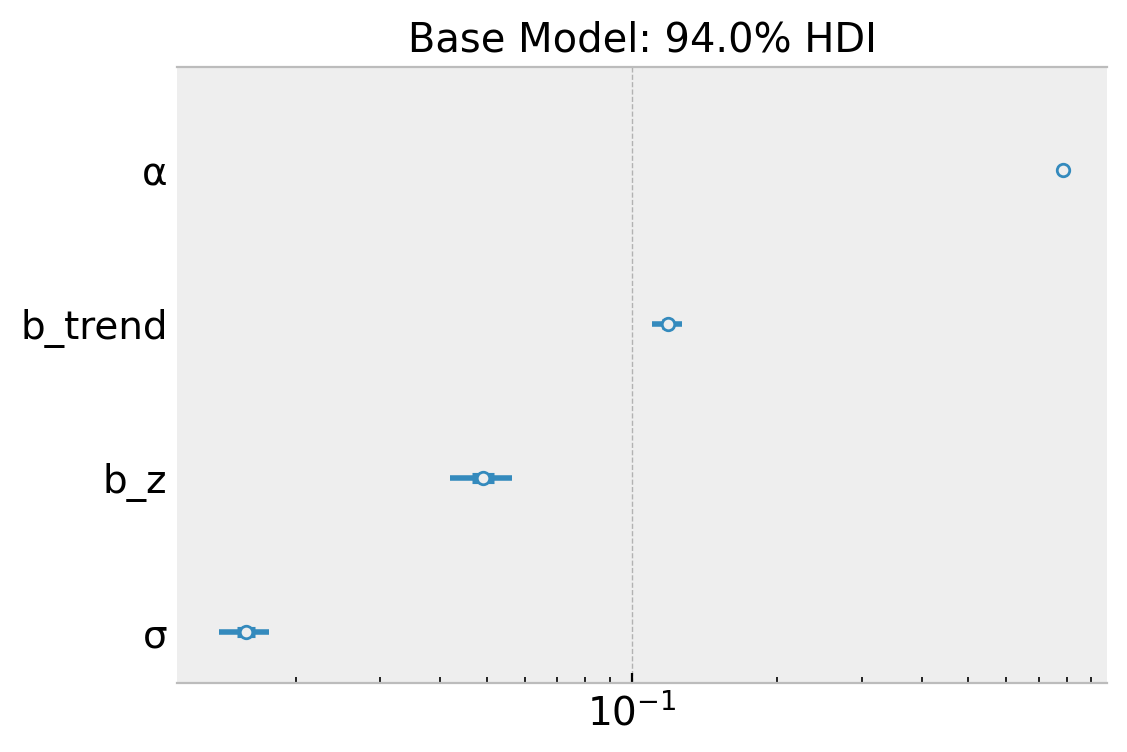

In [52]:
fig, ax = plt.subplots(figsize=(6, 4))
az.plot_forest(
    data=base_model_trace,
    var_names=["α", "b_trend", "b_z", "σ"],
    combined=True,
    ax=ax
)
ax.set(
    title="Base Model: 94.0% HDI",
    xscale="log"
);

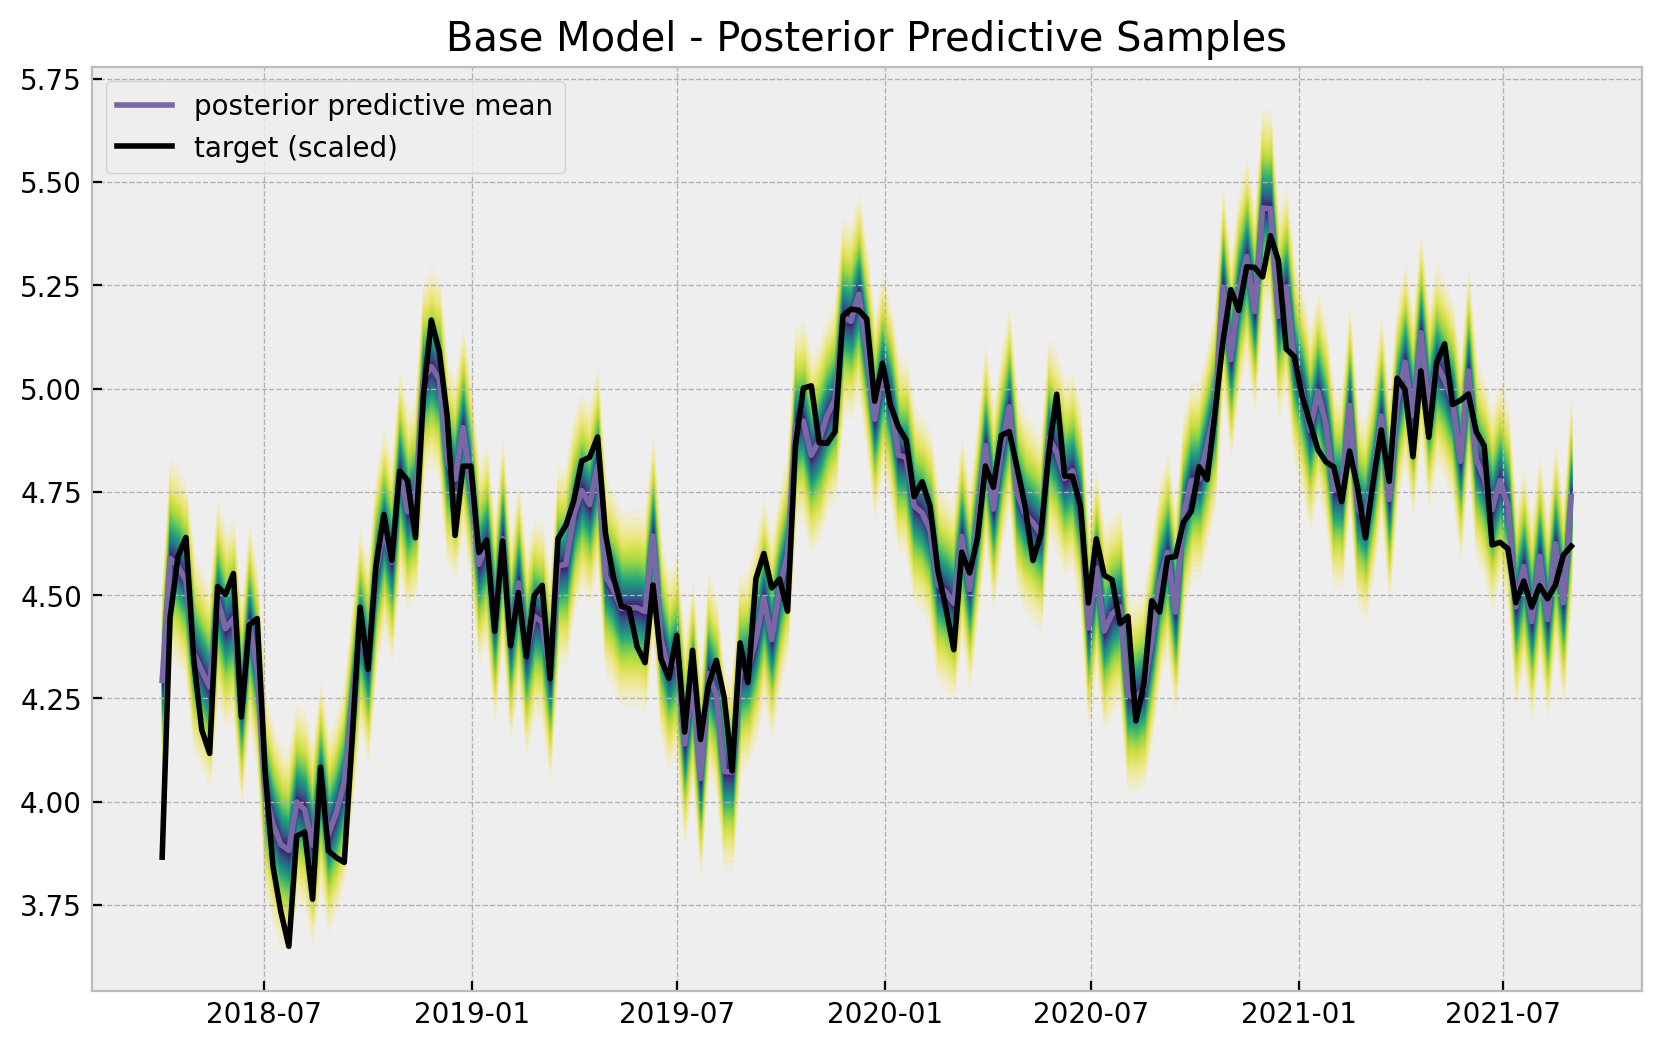

In [55]:
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))

posterior_predictive_likelihood = az.extract(
    data=base_model_posterior_predictive,
    group="posterior_predictive",
    var_names="likelihood",
)

posterior_predictive_likelihood_inv = endog_scaler.inverse_transform(
    X=posterior_predictive_likelihood
)

fig, ax = plt.subplots()

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood_inv, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood_inv, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=date,
    y=posterior_predictive_likelihood_inv.mean(axis=1),
    color="C2",
    label="posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=date,
    y=y,
    color="black",
    label="target (scaled)",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Base Model - Posterior Predictive Samples");

#### Interpreting ArviZ's Summary & plot_trace

# RETURN ON INVESTMENT

In addition to estimating effect of ad spend on our marketing initiatives, it's also important to assess the Return On Investment; in this case, **ROAS** AND **mROAS**

**ROAS** is the change in revenue(or sales) per unit spent on a medium; It's usually calculated by setting spend of the medium to zero in the selected time period and comparing the predicted revenue against that of the current media spend. This can be expressed mathematically as:
$$
    \text{ROAS} = \frac{\sum_{t=0}^{n}\hat{f}(z_t, \epsilon_t) - \hat{f}(0, \epsilon_t)}{\sum_{t=0}^{n}z_t}, \text{where $\hat{f}$ is the posterior predictive distribution and $z_\text{effect} = y - (y - z_\text{effect})$}
$$

In [58]:
roas_true = data_df["z_effect"].sum() / data_df["z"].sum()

In [56]:
base_model_trace_roas = base_model_trace.copy()

with base_model:
    pm.set_data(new_data={"z_scaled": np.zeros_like(a=z_scaled)})
    base_model_trace_roas.extend(
        other=pm.sample_posterior_predictive(trace=base_model_trace_roas, var_names=["likelihood"])
    )

Sampling: [likelihood]


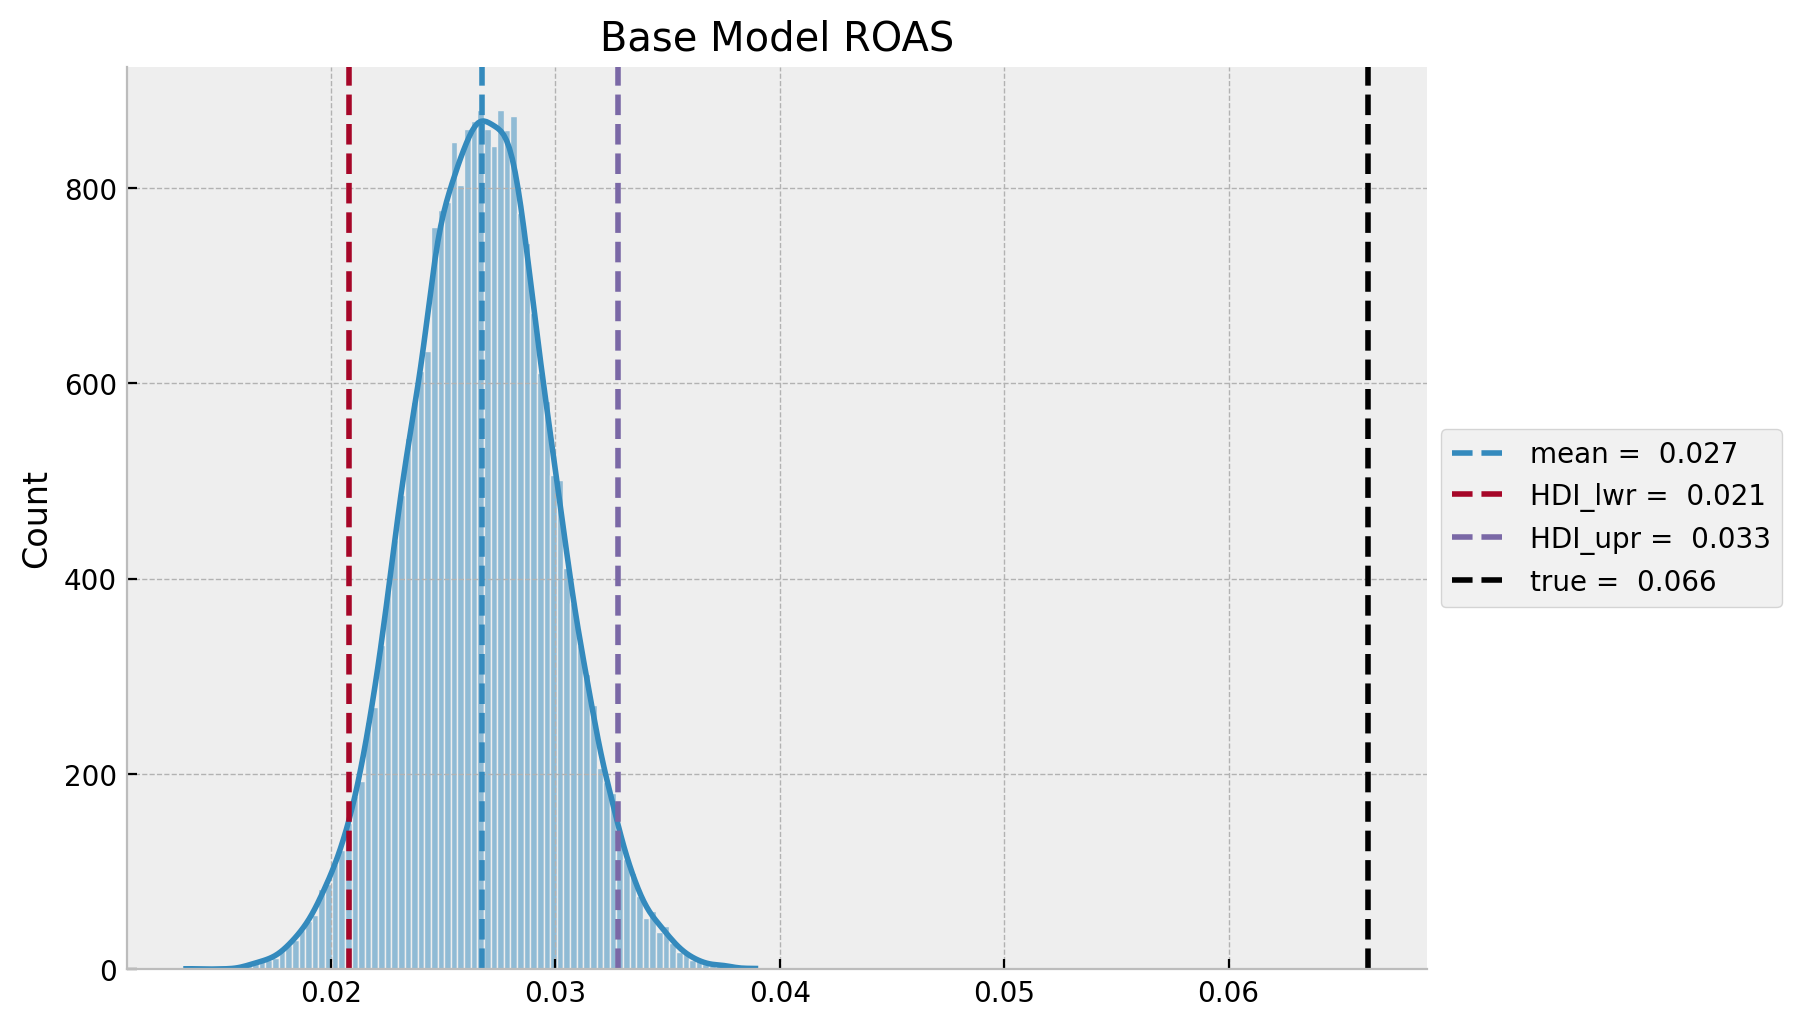

In [59]:
base_roas_numerator = (
    endog_scaler.inverse_transform(
        X=az.extract(
            data=base_model_posterior_predictive,
            group="posterior_predictive",
            var_names=["likelihood"],
        )
    )
    - endog_scaler.inverse_transform(
        X=az.extract(
            data=base_model_trace_roas,
            group="posterior_predictive",
            var_names=["likelihood"],
        )
    )
).sum(axis=0)

roas_denominator = z.sum()

base_roas = base_roas_numerator / roas_denominator
base_roas_mean = base_roas.mean()
base_roas_hdi = az.hdi(ary=base_roas)

g = sns.displot(x=base_roas, kde=True, height=5, aspect=1.5)
ax = g.axes.flatten()[0]
ax.axvline(
    x=base_roas_mean, color="C0", linestyle="--", label=f"mean = {base_roas_mean: 0.3f}"
)
ax.axvline(
    x=base_roas_hdi[0],
    color="C1",
    linestyle="--",
    label=f"HDI_lwr = {base_roas_hdi[0]: 0.3f}",
)
ax.axvline(
    x=base_roas_hdi[1],
    color="C2",
    linestyle="--",
    label=f"HDI_upr = {base_roas_hdi[1]: 0.3f}",
)
ax.axvline(x=roas_true, color="black", linestyle="--", label=f"true = {roas_true: 0.3f}")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Base Model ROAS");